# CRM simulation with SimPy

Simulating wht a CRM system will record from a company's sales process:
- sales funnel simulation
- bidding and project implementation simulation
- reports for sales management

### Imports

In [222]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import simpy

from datetime import datetime, timedelta
from eccore.ipython import nb_setup
from eccore.core import setup_logging, logthis
from enum import Enum
from pathlib import Path
from pprint import pprint
from typing import Any, Callable, Dict, Iterable, List, Optional, Tuple
from uuid import uuid4
from functools import partial


p2log = Path('../logs/sim.log').resolve()
p2log.touch(exist_ok=True)
assert p2log.is_file()
setup_logging(logfile=p2log)
def reset_log(p2log, ):
    # with open(p2log, 'a') as f:
    with open(p2log, 'w') as f:
        f.write(f"{'='* 100}\n")
        f.write(f"New Simulation {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"{'='* 100}\n")

nb_setup()
from agents import Account, SalesRep, MarketingDpt, BaseAgent #type: ignore
from crm import CustomerRelationManagerSimulator   #type: ignore
from enums import AccountStatus, AccountType, AccountStage, Country, Industry, LeadSource # type: ignore
from enums import MktgIntents, SalesIntents, OpsIntents, Actions # type: ignore
from utils import account_info_generator, salesrep_name_generator # type: ignore

# random.seed(1988)

Logging to console and to /home/vtec/projects/diyai/crm-sim/logs/sim.log.
Logging setup finished
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Set autoreload mode


### Simulation

In [223]:
reset_log(p2log, )
crm = CustomerRelationManagerSimulator(
    nb_salesreps=4,
    nb_mql=100,
    nb_sql=100,
    nb_others=20
)
# crm.iterate()
crm.run(until=100)

Created 100 MQL accounts
Created 100 SQL accounts
Created 20 PROSPECT accounts
Created 14 PITCHED accounts
Created 12 BIDDED accounts
Created 7 SIGNED accounts
Total accounts created: 253


In [224]:
df_stats = crm.account_stats_to_df()
nb_weeks = int((df_stats.index[-1] - df_stats.index[0]).total_seconds() /60/60/24/7)
print(f"Simulation ran for {nb_weeks:,d} weeks")

Simulation ran for 98 weeks


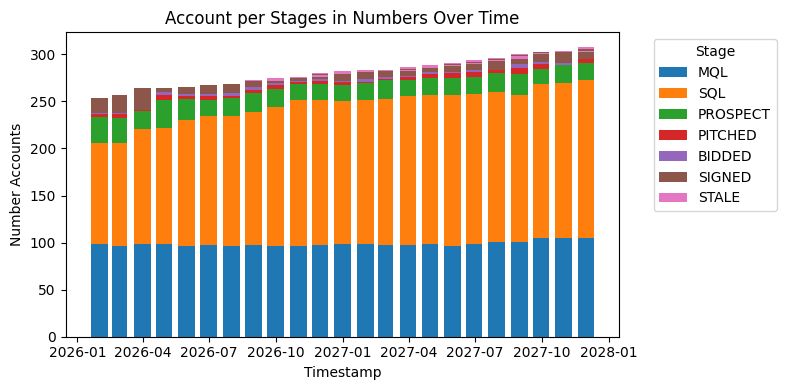

In [225]:
crm.plot_account_stats(as_share=False, hide_mql=False, hide_mql_sql=False)

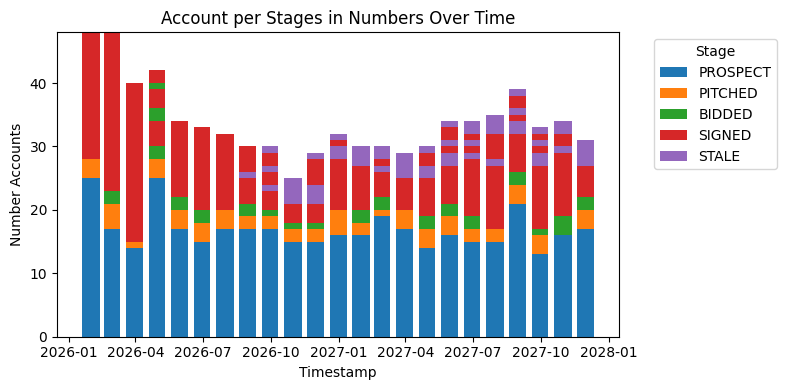

In [265]:
crm.plot_account_stats(as_share=False, hide_mql=True, hide_mql_sql=True)

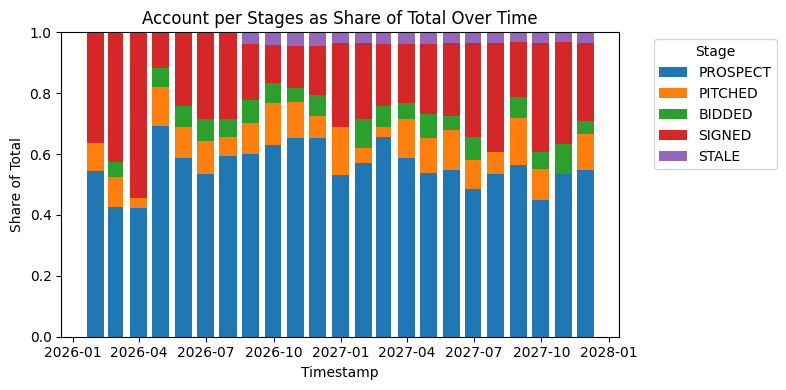

In [ ]:
crm.plot_account_stats(as_share=True, hide_mql=True, hide_mql_sql=True)

In [227]:
df_stats.tail(3)

,nb_accounts,LEAD,MQL,SQL,PROSPECT,PITCHED,BIDDED,SIGNED,ACTIVE,STALE
timestamp,,,,,,,,,,
2027-11-15,308,0,107,171,17,3,3,6,0,1
2027-11-22,308,0,107,173,19,3,0,5,0,1
2027-11-29,308,0,107,172,18,4,2,4,0,1


In [228]:
ddff = crm.transactions_to_df()
ddff.intent.unique()
ddff.columns
# ddff.loc[ddff.loc[:, 'intent'] == 'opportunity', :]
# ddff.loc[ddff.loc[:, 'sender']=='acct-2a8f8ef1-1d85-4bea-9302-f300c58d4d1c'].loc[ddff.loc[:, 'value'].notna(), :]
dddfff = ddff.loc[ddff.loc[:, 'sender']=='acct-ff1da5a0-8221-4a2f-9811-ac001e8de203', :]
dddfff = ddff.loc[ddff.loc[:, 'intent'].isin(['purchase', 'opportunity']), :]
dddfff.loc[dddfff.loc[:,'value'].notna(), :].sort_values(by=['sender'])

,sender,receiver,intent,action,type,value
timestamp,,,,,,
2027-08-16,acct-002207a6-9872-471b-afe0-b7b8597132ea,srep-a347ec50-1616-41ec-8444-f75fcf856574,opportunity,opportunity forecast,external,81000.0
2026-04-20,acct-016ef6ba-f1b6-40d1-8fdb-0807b852c7d8,srep-a347ec50-1616-41ec-8444-f75fcf856574,purchase,purchase value,external,186000.0
2027-08-16,acct-016ef6ba-f1b6-40d1-8fdb-0807b852c7d8,srep-a347ec50-1616-41ec-8444-f75fcf856574,opportunity,opportunity forecast,external,215000.0
2026-04-13,acct-016ef6ba-f1b6-40d1-8fdb-0807b852c7d8,srep-a347ec50-1616-41ec-8444-f75fcf856574,opportunity,opportunity forecast,external,186000.0
2026-10-05,acct-02183477-6eea-4809-b482-39cb36225161,srep-a347ec50-1616-41ec-8444-f75fcf856574,opportunity,opportunity forecast,external,13000.0
...,...,...,...,...,...,...
2027-11-08,acct-f9a61759-6018-4537-8ace-bc76a0be8244,srep-a347ec50-1616-41ec-8444-f75fcf856574,opportunity,opportunity forecast,external,579000.0
2027-08-02,acct-f9a61759-6018-4537-8ace-bc76a0be8244,srep-a347ec50-1616-41ec-8444-f75fcf856574,opportunity,opportunity forecast,external,790000.0
2027-08-09,acct-f9a61759-6018-4537-8ace-bc76a0be8244,srep-a347ec50-1616-41ec-8444-f75fcf856574,purchase,purchase value,external,790000.0


In [229]:
bizval = ddff.loc[ddff.loc[:, 'intent'].isin(['purchase', 'opportunity']), :]
opportunities = ddff.loc[ddff.loc[:, 'intent'].isin(['opportunity']), :]
purchases = ddff.loc[ddff.loc[:, 'intent'].isin(['purchase']), :]
bizval = bizval.sort_index().sort_values(by=['sender','timestamp'], ascending=True)
display(bizval.head())
display(opportunities.head())
display(purchases.head())
# bizval.loc[bizval.loc[:, 'sender']=='acct-03c631e1-3150-44b8-b97e-27aba24e9924']

,sender,receiver,intent,action,type,value
timestamp,,,,,,
2027-08-16,acct-002207a6-9872-471b-afe0-b7b8597132ea,srep-a347ec50-1616-41ec-8444-f75fcf856574,opportunity,opportunity forecast,external,81000.0
2026-04-13,acct-016ef6ba-f1b6-40d1-8fdb-0807b852c7d8,srep-a347ec50-1616-41ec-8444-f75fcf856574,opportunity,opportunity forecast,external,186000.0
2026-04-20,acct-016ef6ba-f1b6-40d1-8fdb-0807b852c7d8,srep-a347ec50-1616-41ec-8444-f75fcf856574,purchase,purchase value,external,186000.0
2027-08-16,acct-016ef6ba-f1b6-40d1-8fdb-0807b852c7d8,srep-a347ec50-1616-41ec-8444-f75fcf856574,opportunity,opportunity forecast,external,215000.0
2026-10-05,acct-02183477-6eea-4809-b482-39cb36225161,srep-a347ec50-1616-41ec-8444-f75fcf856574,opportunity,opportunity forecast,external,13000.0


,sender,receiver,intent,action,type,value
timestamp,,,,,,
2026-01-05,acct-d59a23d0-a458-48b0-9a79-eed77cb96e4b,srep-a347ec50-1616-41ec-8444-f75fcf856574,opportunity,opportunity forecast,external,126000.0
2026-01-05,acct-7185c5ae-e186-4e4f-8d07-d41be3d5556a,srep-a347ec50-1616-41ec-8444-f75fcf856574,opportunity,opportunity forecast,external,34000.0
2026-01-05,acct-c4954d08-39cb-4e25-9dab-b084e44c1986,srep-a347ec50-1616-41ec-8444-f75fcf856574,opportunity,opportunity forecast,external,56000.0
2026-01-12,acct-95ce549d-c5e7-4b52-a0cb-e22876a007a2,srep-a347ec50-1616-41ec-8444-f75fcf856574,opportunity,opportunity forecast,external,232000.0
2026-01-12,acct-a5f9162e-9dd5-4400-bda3-865637d13349,srep-a347ec50-1616-41ec-8444-f75fcf856574,opportunity,opportunity forecast,external,119000.0


,sender,receiver,intent,action,type,value
timestamp,,,,,,
2026-01-05,acct-7f5ac252-2099-40a2-8621-f1db1fe32f89,srep-a347ec50-1616-41ec-8444-f75fcf856574,purchase,purchase value,external,0.0
2026-01-12,acct-d59a23d0-a458-48b0-9a79-eed77cb96e4b,srep-a347ec50-1616-41ec-8444-f75fcf856574,purchase,purchase value,external,126000.0
2026-01-12,acct-8e384825-2427-4174-b7f6-517461e2d38a,srep-a347ec50-1616-41ec-8444-f75fcf856574,purchase,purchase value,external,0.0
2026-01-12,acct-7185c5ae-e186-4e4f-8d07-d41be3d5556a,srep-a347ec50-1616-41ec-8444-f75fcf856574,purchase,purchase value,external,34000.0
2026-01-12,acct-c4954d08-39cb-4e25-9dab-b084e44c1986,srep-a347ec50-1616-41ec-8444-f75fcf856574,purchase,purchase value,external,56000.0


In [230]:
opps_per_account = opportunities.groupby(by=['sender']).agg({ 'receiver':'last','intent': 'count', 'action': 'last', 'value':'sum'})
opps_per_account

,receiver,intent,action,value
sender,,,,
acct-002207a6-9872-471b-afe0-b7b8597132ea,srep-a347ec50-1616-41ec-8444-f75fcf856574,1,opportunity forecast,81000.0
acct-016ef6ba-f1b6-40d1-8fdb-0807b852c7d8,srep-a347ec50-1616-41ec-8444-f75fcf856574,2,opportunity forecast,401000.0
acct-02183477-6eea-4809-b482-39cb36225161,srep-a347ec50-1616-41ec-8444-f75fcf856574,1,opportunity forecast,13000.0
acct-0310e489-0db3-4a97-8ea6-a75b3b265a8d,srep-a347ec50-1616-41ec-8444-f75fcf856574,1,opportunity forecast,34000.0
acct-03340430-76e0-4dc0-b01f-ff521dccd647,srep-a347ec50-1616-41ec-8444-f75fcf856574,1,opportunity forecast,123000.0
...,...,...,...,...
acct-f614b1fa-943c-473f-97cd-7b0bb39c14a9,srep-a347ec50-1616-41ec-8444-f75fcf856574,1,opportunity forecast,29000.0
acct-f7699640-4347-4769-901c-805326f511e0,srep-a347ec50-1616-41ec-8444-f75fcf856574,3,opportunity forecast,75000.0
acct-f9a61759-6018-4537-8ace-bc76a0be8244,srep-a347ec50-1616-41ec-8444-f75fcf856574,2,opportunity forecast,1369000.0


In [231]:
pos_per_account = purchases.groupby(by=['sender']).agg({ 'receiver':'last','intent': 'count', 'action': 'last', 'value':'sum'})
pos_per_account

,receiver,intent,action,value
sender,,,,
acct-016ef6ba-f1b6-40d1-8fdb-0807b852c7d8,srep-a347ec50-1616-41ec-8444-f75fcf856574,1,purchase value,186000.0
acct-0310e489-0db3-4a97-8ea6-a75b3b265a8d,srep-a347ec50-1616-41ec-8444-f75fcf856574,1,purchase value,34000.0
acct-03340430-76e0-4dc0-b01f-ff521dccd647,srep-a347ec50-1616-41ec-8444-f75fcf856574,1,purchase value,123000.0
acct-12579123-99d3-458a-9994-fcd8c64303fa,srep-a347ec50-1616-41ec-8444-f75fcf856574,2,purchase value,45000.0
acct-1361da5e-1699-45ce-b6b8-dbbce570444b,srep-a347ec50-1616-41ec-8444-f75fcf856574,1,purchase value,0.0
acct-183a0b1a-7c25-4b55-b2f4-de13e57d5661,srep-a347ec50-1616-41ec-8444-f75fcf856574,1,purchase value,96000.0
acct-21260598-5636-4f15-bf81-d22c2051e701,srep-a347ec50-1616-41ec-8444-f75fcf856574,1,purchase value,229000.0
acct-2a0b1f5e-2bcb-4c58-862e-ce961f10d5da,srep-a347ec50-1616-41ec-8444-f75fcf856574,2,purchase value,399000.0
acct-2bf7a745-a944-4111-a826-4d58f29e77c6,srep-a347ec50-1616-41ec-8444-f75fcf856574,1,purchase value,30000.0


In [232]:
business_per_account = pd.merge(left=opps_per_account.loc[:, ['intent', 'value']], right=pos_per_account.loc[:, ['intent', 'value']], how='left', left_index=True, right_index=True, suffixes=('_opp', '_po'))
business_per_account = pd.merge(left=business_per_account, right=crm.account_df().loc[:, ['name', 'account_type','industry', 'country', 'cumulative_opportunity_value', 'cumulative_purchase_value', 'nb_opportunities', 'nb_purchases', 'uid']], how='left', left_index=True, right_on='uid')
business_per_account.columns = '|'.join(business_per_account.columns).replace('intent_', 'nb_').split('|')
business_per_account['avg_opp'] = business_per_account['value_opp'] / business_per_account['nb_opp']
business_per_account['avg_po'] = business_per_account['value_po'].div(business_per_account['nb_po'])
business_per_account['success_rate_value'] = business_per_account['value_po']/business_per_account['value_opp']
business_per_account['success_rate_nb'] = business_per_account['nb_po']/business_per_account['nb_opp']
business_per_account = business_per_account.fillna(0)
business_per_account.head()

,nb_opp,value_opp,nb_po,value_po,name,account_type,industry,country,cumulative_opportunity_value,cumulative_purchase_value,nb_opportunities,nb_purchases,uid,avg_opp,avg_po,success_rate_value,success_rate_nb
120,1,81000.0,0.0,0.0,KedahFlex Industries,MEDIUM,PackagingSI,CN,81000,0,1,0,acct-002207a6-9872-471b-afe0-b7b8597132ea,81000.0,0.0,0.00000,0.0
233,2,401000.0,1.0,186000.0,"AnyangFlex Co., Ltd.",MEDIUM,Chemicals,CN,401000,186000,2,0,acct-016ef6ba-f1b6-40d1-8fdb-0807b852c7d8,200500.0,186000.0,0.46384,0.5
134,1,13000.0,0.0,0.0,ProgressivePack LLC,SMALL,ConsumerGoods,US,13000,0,1,0,acct-02183477-6eea-4809-b482-39cb36225161,13000.0,0.0,0.00000,0.0
220,1,34000.0,1.0,34000.0,ElitePac Solutions LLC,SMALL,IndustrialManufacturing,US,34000,34000,1,0,acct-0310e489-0db3-4a97-8ea6-a75b3b265a8d,34000.0,34000.0,1.00000,1.0
169,1,123000.0,1.0,123000.0,SarawakFlex Industries,MEDIUM,PackagingSI,CN,123000,123000,1,0,acct-03340430-76e0-4dc0-b01f-ff521dccd647,123000.0,123000.0,1.00000,1.0


In [233]:
def plot_funnel_biz(df, title=None, figsize=(8, 3)):
    # reversed_cols = funnel.columns[::-1]
    fig,ax = plt.subplots(figsize=figsize)
    bars = df.T.plot(kind='barh', ax=ax, title=title or 'Conversion Rates')
    ax.invert_yaxis()
    # Add value labels to each bar
    max_val = df.max()
    ax.set_xlim(0, max_val * 1.15)  # Add 15% padding to the right
    for i, v in enumerate(df.values):
        ax.text(v + 0.01, i, f"{v:.2f}", va='center', ha='left',fontsize=10)
    plt.show()

In [234]:
business_per_account.groupby(by='account_type').agg({'success_rate_value':'mean','success_rate_nb':'mean','avg_opp':'mean','avg_po':'mean','value_opp':'sum','value_po':'sum','nb_opp':'sum','nb_po':'sum'})

,success_rate_value,success_rate_nb,avg_opp,avg_po,value_opp,value_po,nb_opp,nb_po
account_type,,,,,,,,
LARGE,0.525902,0.528571,660552.380952,417009.523810,32991000.0,16913000.0,51,27.0
MEDIUM,0.454258,0.484649,156835.526316,88250.000000,8218000.0,4193000.0,52,26.0
SMALL,0.185776,0.186404,26686.403509,8197.368421,1691000.0,334000.0,63,12.0


In [235]:
biz_per_ind = business_per_account.groupby(by='industry').agg({'success_rate_value':'mean','success_rate_nb':'mean','avg_opp':'mean','avg_po':'mean','value_opp':'sum','value_po':'sum','nb_opp':'sum','nb_po':'sum'})
biz_per_ind

,success_rate_value,success_rate_nb,avg_opp,avg_po,value_opp,value_po,nb_opp,nb_po
industry,,,,,,,,
AutomotiveParts,0.333333,0.333333,300805.555556,206500.000000,2170000.0,1239000.0,9,2.0
Chemicals,0.474334,0.470588,301588.235294,224235.294118,7198000.0,4039000.0,23,11.0
ConsumerGoods,0.434727,0.416667,462291.666667,308916.666667,8454000.0,4572000.0,17,8.0
Electronics,0.301405,0.294118,176362.745098,151411.764706,3815000.0,2574000.0,27,7.0
FoodnBeverage,0.431046,0.421569,245176.470588,126607.843137,6447000.0,3510000.0,26,11.0
IndustrialManufacturing,0.517512,0.531250,255906.250000,119687.500000,5892000.0,2115000.0,25,12.0
PackagingSI,0.237212,0.333333,270435.897436,93423.076923,4921000.0,1237000.0,21,8.0
Pharmaceuticals,0.279373,0.307692,218269.230769,126653.846154,4003000.0,2154000.0,18,6.0


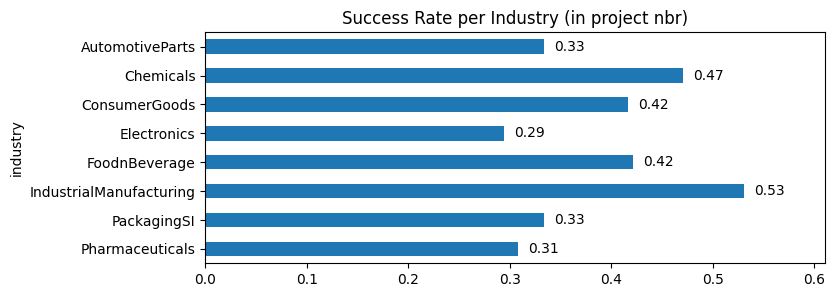

In [268]:
plot_funnel_biz(biz_per_ind.loc[:,'success_rate_nb'], title= f"Success Rate per Industry (in project nbr)")

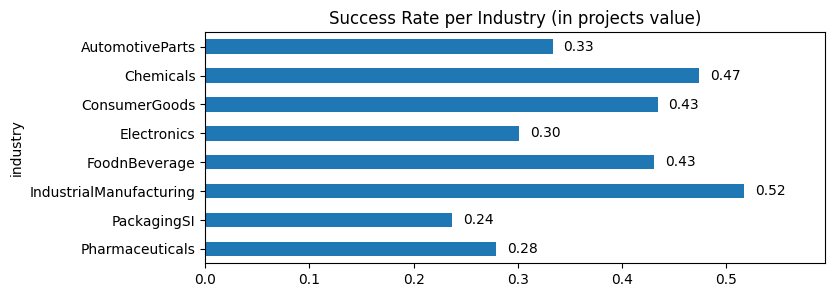

In [237]:
plot_funnel_biz(biz_per_ind.loc[:,'success_rate_value'], title= f"Success Rate per Industry (in projects value)")

In [238]:
biz_per_country = business_per_account.groupby(by='country').agg({'success_rate_value':'mean','success_rate_nb':'mean','avg_opp':'mean','avg_po':'mean','value_opp':'sum','value_po':'sum','nb_opp':'sum','nb_po':'sum'})
biz_per_country

,success_rate_value,success_rate_nb,avg_opp,avg_po,value_opp,value_po,nb_opp,nb_po
country,,,,,,,,
CN,0.392807,0.433333,281350.000000,162866.666667,12261000.0,4886000.0,39,16.0
EU,0.384414,0.380952,282629.629630,181076.719577,25517000.0,14080000.0,105,40.0
US,0.373644,0.388889,213722.222222,109250.000000,5122000.0,2474000.0,22,9.0


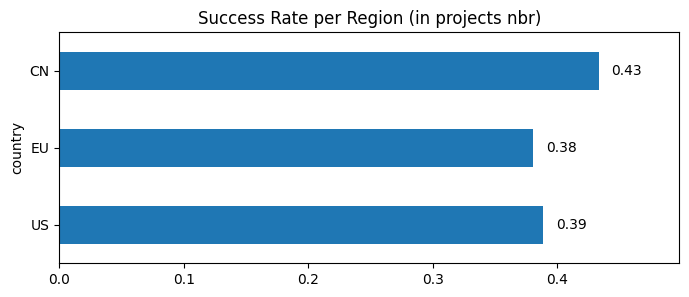

In [239]:
plot_funnel_biz(biz_per_country.loc[:,'success_rate_nb'], title= f"Success Rate per Region (in projects nbr)")

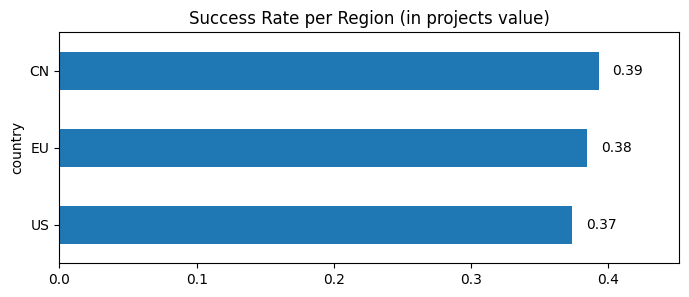

In [240]:
plot_funnel_biz(biz_per_country.loc[:,'success_rate_value'], title= f"Success Rate per Region (in projects value)")

In [241]:
biz_per_type = business_per_account.groupby(by='account_type').agg({'success_rate_value':'mean','success_rate_nb':'mean','avg_opp':'mean','avg_po':'mean','value_opp':'sum','value_po':'sum','nb_opp':'sum','nb_po':'sum'})
biz_per_type

,success_rate_value,success_rate_nb,avg_opp,avg_po,value_opp,value_po,nb_opp,nb_po
account_type,,,,,,,,
LARGE,0.525902,0.528571,660552.380952,417009.523810,32991000.0,16913000.0,51,27.0
MEDIUM,0.454258,0.484649,156835.526316,88250.000000,8218000.0,4193000.0,52,26.0
SMALL,0.185776,0.186404,26686.403509,8197.368421,1691000.0,334000.0,63,12.0


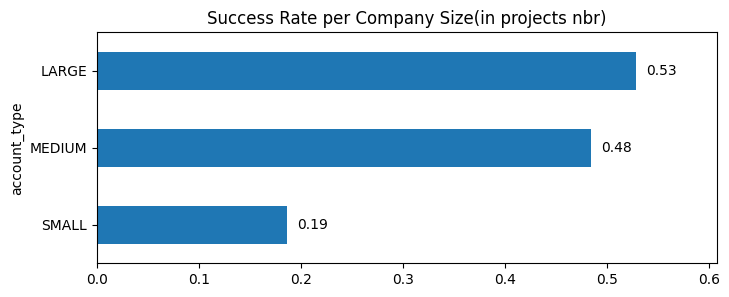

In [242]:
plot_funnel_biz(biz_per_type.loc[:,'success_rate_nb'], title= f"Success Rate per Company Size(in projects nbr)")

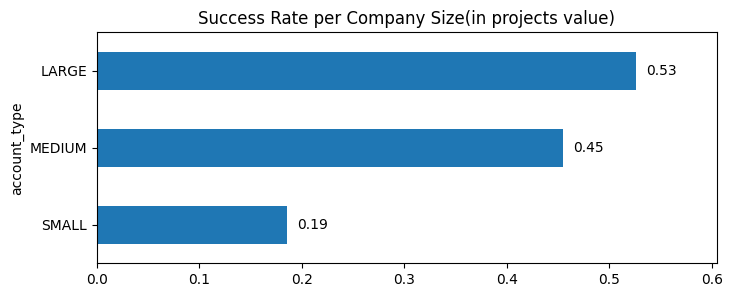

In [243]:
plot_funnel_biz(biz_per_type.loc[:,'success_rate_value'], title= f"Success Rate per Company Size(in projects value)")

### Funnel Analysis

In [244]:
df = crm.transactions_to_df()
df.loc[df.action == 'transition',:].intent.unique()

array(['SQL to SQL', 'SQL to PROSPECT', 'PITCHED to BIDDED',
       'PITCHED to SQL', 'BIDDED to SQL', 'BIDDED to SIGNED',
       'MQL to SQL', 'PROSPECT to PITCHED', 'PROSPECT to SQL',
       'SIGNED to PROSPECT', 'SIGNED to STALE'], dtype=object)

In [245]:
coi = [
    # 'MQL to SQL',
    'SQL to PROSPECT', 
    'SQL to SQL', 
    'PROSPECT to PITCHED', 
    'PROSPECT to SQL', 
    'PITCHED to BIDDED', 
    'PITCHED to SQL',
    'BIDDED to SIGNED',
    'BIDDED to SQL',
    'SIGNED to PROSPECT', 
    'SIGNED to STALE'
       ]
coi_success = [
    # 'MQL to SQL',
    'SQL to PROSPECT', 
    'PROSPECT to PITCHED', 
    'PITCHED to BIDDED', 
    'BIDDED to SIGNED',
    'SIGNED to PROSPECT', 
       ]
coi_fail = [
    # 'MQL to SQL',
    'SQL to SQL', 
    'PROSPECT to SQL', 
    'PITCHED to SQL',
    'BIDDED to SQL',
    'SIGNED to STALE'
       ]
funnel_trans = df.loc[df.action == 'transition',:]

In [246]:
funnel_trans.groupby('intent').count()

,sender,receiver,action,type,value
intent,,,,,
BIDDED to SIGNED,134,134,134,134,0
BIDDED to SQL,216,216,216,216,0
MQL to SQL,50,50,50,50,0
PITCHED to BIDDED,332,332,332,332,0
PITCHED to SQL,324,324,324,324,0
PROSPECT to PITCHED,634,634,634,634,0
PROSPECT to SQL,586,586,586,586,0
SIGNED to PROSPECT,138,138,138,138,0
SIGNED to STALE,2,2,2,2,0


In [247]:
cois = {
    # 'MQL to SQL': 'MQL',
    'SQL to PROSPECT': 'SQL',
    'PROSPECT to PITCHED': 'PROSPECT',
    'PITCHED to BIDDED': 'PITCHED',
    'BIDDED to SIGNED': 'BIDDED',
    'SIGNED to PROSPECT': 'SIGNED',
}

list(map(lambda x: cois[x], ['SQL to PROSPECT', 'PROSPECT to PITCHED', 'PITCHED to BIDDED', 'BIDDED to SIGNED', 'SIGNED to PROSPECT']))

['SQL', 'PROSPECT', 'PITCHED', 'BIDDED', 'SIGNED']

In [248]:
def build_funnel(df):
    coi_success = {
        # 'MQL to SQL': 'MQL',
        'SQL to PROSPECT': 'SQL',
        'PROSPECT to PITCHED': 'PROSPECT',
        'PITCHED to BIDDED': 'PITCHED',
        'BIDDED to SIGNED': 'BIDDED',
        'SIGNED to PROSPECT': 'SIGNED',
    }
    coi_fail = {
        # 'MQL to SQL': 'MQL,
        'SQL to SQL': 'SQL',
        'PROSPECT to SQL': 'PROSPECT',
        'PITCHED to SQL': 'PITCHED',
        'BIDDED to SQL': 'BIDDED',
        'SIGNED to STALE': 'SIGNED',
    }
    def _funnel(df, cois, coif, aggfn:str):
        t_success = df.groupby(by='intent').agg(aggfn).T
        cols = [k for k, v in cois.items() if k in t_success.columns]
        t_success = t_success.loc[['action'],cols]
        cols = list(map(lambda x: cois[x], list(t_success.columns)))
        t_success.columns = cols
        t_fail = df.groupby(by='intent').agg(aggfn).T
        cols = [k for k, v in coif.items() if k in t_fail.columns]
        t_fail = t_fail.loc[['action'],cols]
        cols = list(map(lambda x: coif[x], list(t_fail.columns)))
        t_fail.columns = cols
        funnel = pd.concat([t_success, t_fail], axis=0)
        funnel.index = ['success', 'failed'] #type: ignore
        funnel.loc['total', :] = funnel.sum()
        return funnel
    
    funnels = {}
    if isinstance(df.index, pd.MultiIndex):
        for idx in list(set([idx[0] for idx in df.index])):
            funnels[idx] = _funnel(df.loc[(idx,),:], coi_success, coi_fail, 'sum')
    else:
        funnels['all'] = _funnel(df, coi_success, coi_fail, 'sum')
    return funnels

In [249]:
funnel_dict = build_funnel(funnel_trans.groupby('intent').count())
funnel_dict['all']

,SQL,PROSPECT,PITCHED,BIDDED,SIGNED
success,1072.0,634.0,332.0,134.0,138.0
failed,528.0,586.0,324.0,216.0,2.0
total,1600.0,1220.0,656.0,350.0,140.0


In [250]:
def plot_funnel(funnel, title=None, figsize=(8, 3)):
    # reversed_cols = funnel.columns[::-1]
    fig,ax = plt.subplots(figsize=figsize)
    df = funnel.loc['total', :] / funnel.loc['total','SQL']
    bars = df.clip(upper=1).T.plot(kind='barh', ax=ax, title=title or 'Conversion Rates')
    ax.invert_yaxis()
    # Add value labels to each bar
    max_val = df.max()
    ax.set_xlim(0, max_val * 1.15)  # Add 15% padding to the right
    for i, v in enumerate(df.values):
        ax.text(v + 0.01, i, f"{v:.2f}", va='center', ha='left',fontsize=10)
    plt.show()

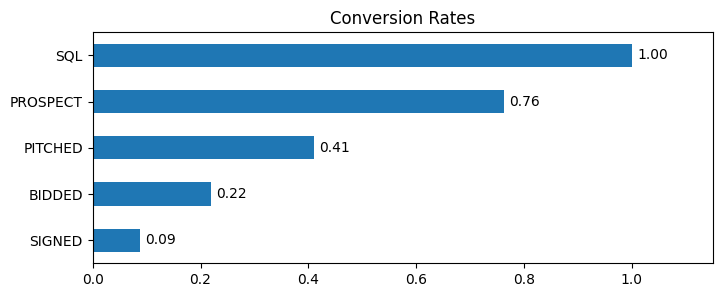

In [251]:
plot_funnel(funnel_dict['all'])

In [252]:
wkly_avg = funnel_dict['all'] / nb_weeks
print('Weekly Average:')
wkly_avg

Weekly Average:


,SQL,PROSPECT,PITCHED,BIDDED,SIGNED
success,10.938776,6.469388,3.387755,1.367347,1.408163
failed,5.387755,5.979592,3.306122,2.204082,0.020408
total,16.326531,12.448980,6.693878,3.571429,1.428571


### Build Detailed Dataset

In [253]:
funnel_uid = funnel_trans.receiver.unique()
print(len(funnel_uid), 'accounts in the funnel')
print(' | '.join(funnel_uid[:3]))
funnel_trans.tail(3)

203 accounts in the funnel
acct-e3b674f8-4ce8-4a02-a08d-ad5f6dc3503f | acct-f7699640-4347-4769-901c-805326f511e0 | acct-44132d3d-224c-43a7-b173-c319d1fa6c39


,sender,receiver,intent,action,type,value
timestamp,,,,,,
2027-12-01 02:24:00,srep-378487f8-de3b-408b-b066-a16d86348da5,acct-2a0b1f5e-2bcb-4c58-862e-ce961f10d5da,SQL to SQL,transition,internal,NaN
2027-12-05 07:12:00,crm-71f0bea9-15c6-47e9-8558-5727c3c87755,acct-448a4475-6f3f-48e8-98e5-9810f0a84bdf,MQL to SQL,transition,system,NaN
2027-12-05 07:12:00,crm-71f0bea9-15c6-47e9-8558-5727c3c87755,acct-ceb630fd-1081-4721-8609-f98f7ef4d9bd,MQL to SQL,transition,system,NaN


In [254]:
acct_ds = crm.account_df()
acct_uid = acct_ds['uid'].unique()
print(len(acct_uid), 'accounts in the crm record')
print((' | '.join(acct_uid[:3])))
acct_ds.tail(3)

310 accounts in the crm record
acct-f8b322e3-13a7-4e47-bfe7-a0549c0560cd | acct-532c8872-cc94-4236-98b0-d34b2c88b602 | acct-cd7df71f-1b39-413e-b49c-ba9a92ab3c64


,account_type,assigned_salesrep,country,cumulative_opportunity_value,cumulative_purchase_value,industry,lead_source,name,nb_opportunities,nb_purchases,stage,uid
307,LARGE,srep-a347ec50-1616-41ec-8444-f75fcf856574,US,0,0,Chemicals,EMAIL_CAMPAIGN,CoreFlex Inc.,0,0,MQL,acct-8cf678eb-ada4-4c6c-a83b-c11a6daf3c0f
308,LARGE,srep-a347ec50-1616-41ec-8444-f75fcf856574,CN,0,0,ConsumerGoods,SALES_REP,"YichunWrap Co., Ltd.",0,0,MQL,acct-95055113-ae59-4546-8abb-b243fcb4478f
309,MEDIUM,srep-a347ec50-1616-41ec-8444-f75fcf856574,US,0,0,PackagingSI,EMAIL_CAMPAIGN,StrategicWrap Inc.,0,0,MQL,acct-092d50ad-35dc-4cd7-b809-80d202f443e4


In [255]:
srep_ds = crm.salesrep_df()
srep_uid = srep_ds.uid.unique()
print(len(srep_ds), 'sales reps in the crm record')
print((' | '.join(srep_uid[:3])))
srep_ds.tail(3)

4 sales reps in the crm record
srep-a347ec50-1616-41ec-8444-f75fcf856574 | srep-fbb199da-24d3-4d76-960c-583337a82e85 | srep-e56abfb0-0177-409a-a334-43afb365a059


,name,uid
1,SalesRep 2,srep-fbb199da-24d3-4d76-960c-583337a82e85
2,SalesRep 3,srep-e56abfb0-0177-409a-a334-43afb365a059
3,SalesRep 4,srep-378487f8-de3b-408b-b066-a16d86348da5


In [256]:
print(f"{len(set(acct_uid).intersection(set(funnel_uid))):,d} accounts in the funnel")
# print(f"{len(set(srep_uid).intersection(set(funnel_uid))):,d} accounts in the funnel")

203 accounts in the funnel


In [257]:
funnel_ds = pd.merge(left=funnel_trans, right=acct_ds, how='left', left_on='receiver', right_on='uid')
print(funnel_ds.shape)
print(funnel_ds.uid.unique().shape)
funnel_ds.head(3)

(4016, 18)
(203,)


,sender,receiver,intent,action,type,value,account_type,assigned_salesrep,country,cumulative_opportunity_value,cumulative_purchase_value,industry,lead_source,name,nb_opportunities,nb_purchases,stage,uid
0,crm-71f0bea9-15c6-47e9-8558-5727c3c87755,acct-e3b674f8-4ce8-4a02-a08d-ad5f6dc3503f,SQL to SQL,transition,system,NaN,MEDIUM,srep-a347ec50-1616-41ec-8444-f75fcf856574,CN,0,0,Electronics,EXISTING_CUSTOMER,SuzhouFlex Industries,0,0,SQL,acct-e3b674f8-4ce8-4a02-a08d-ad5f6dc3503f
1,srep-378487f8-de3b-408b-b066-a16d86348da5,acct-e3b674f8-4ce8-4a02-a08d-ad5f6dc3503f,SQL to SQL,transition,internal,NaN,MEDIUM,srep-a347ec50-1616-41ec-8444-f75fcf856574,CN,0,0,Electronics,EXISTING_CUSTOMER,SuzhouFlex Industries,0,0,SQL,acct-e3b674f8-4ce8-4a02-a08d-ad5f6dc3503f
2,crm-71f0bea9-15c6-47e9-8558-5727c3c87755,acct-f7699640-4347-4769-901c-805326f511e0,SQL to SQL,transition,system,NaN,SMALL,srep-a347ec50-1616-41ec-8444-f75fcf856574,EU,75000,0,FoodnBeverage,EXISTING_CUSTOMER,PisaPac S.p.A.,3,0,SQL,acct-f7699640-4347-4769-901c-805326f511e0


In [258]:
funnel_per_type = funnel_ds.groupby(by=['account_type', 'intent']).count().loc[:, ['action']]
funnel_per_type

action
account_type intent                     
LARGE        BIDDED to SIGNED         54
             BIDDED to SQL            50
             MQL to SQL               17
             PITCHED to BIDDED       102
             PITCHED to SQL          122
             PROSPECT to PITCHED     226
             PROSPECT to SQL         226
             SIGNED to PROSPECT       58
             SQL to PROSPECT         382
             SQL to SQL              186
MEDIUM       BIDDED to SIGNED         56
             BIDDED to SQL            52
             MQL to SQL               16
             PITCHED to BIDDED       104
             PITCHED to SQL          104
             PROSPECT to PITCHED     196
             PROSPECT to SQL         202
             SIGNED to PROSPECT       52
             SIGNED to STALE           2
             SQL to PROSPECT         342
             SQL to SQL              174
SMALL        BIDDED to SIGNED         24
             BIDDED to SQL           114
             MQL to SQL               17
             PITCHED to BIDDED       126
             PITCHED to SQL           98
             PROSPECT to PITCHED     212
             PROSPECT to SQL         158
             SIGNED to PROSPECT       28
             SQL to PROSPECT         348
             SQL to SQL              168

,SQL,PROSPECT,PITCHED,BIDDED,SIGNED
success,348.0,212.0,126.0,24.0,28.0
failed,168.0,158.0,98.0,114.0,NaN
total,516.0,370.0,224.0,138.0,28.0


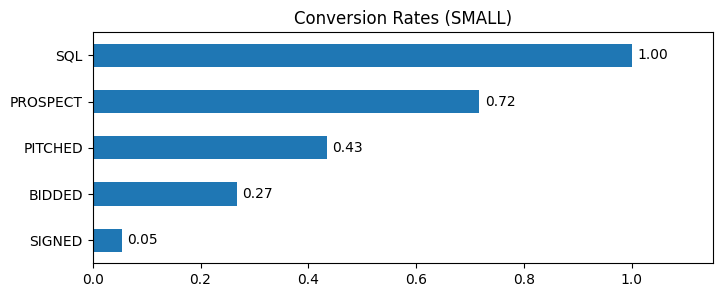

,SQL,PROSPECT,PITCHED,BIDDED,SIGNED
success,342.0,196.0,104.0,56.0,52.0
failed,174.0,202.0,104.0,52.0,2.0
total,516.0,398.0,208.0,108.0,54.0


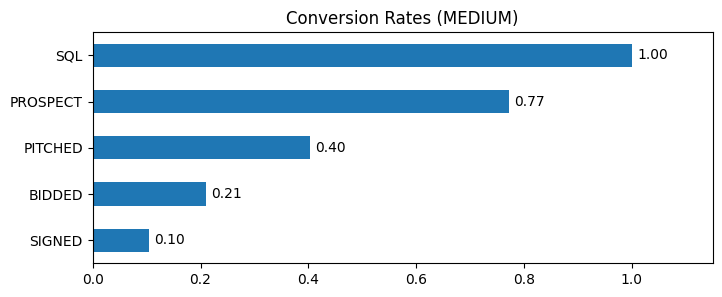

,SQL,PROSPECT,PITCHED,BIDDED,SIGNED
success,382.0,226.0,102.0,54.0,58.0
failed,186.0,226.0,122.0,50.0,NaN
total,568.0,452.0,224.0,104.0,58.0


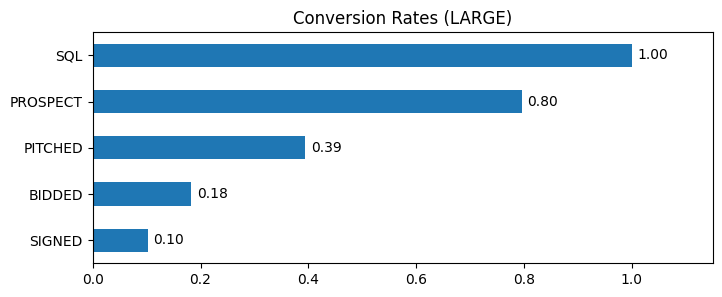

In [259]:
funnel_dict_per_type = build_funnel(funnel_per_type)
for k,v in funnel_dict_per_type.items():
    display(v)
    plot_funnel(v, title=f"Conversion Rates ({k})",figsize=(8, 3))

In [260]:
funnel_ds.head(3)

,sender,receiver,intent,action,type,value,account_type,assigned_salesrep,country,cumulative_opportunity_value,cumulative_purchase_value,industry,lead_source,name,nb_opportunities,nb_purchases,stage,uid
0,crm-71f0bea9-15c6-47e9-8558-5727c3c87755,acct-e3b674f8-4ce8-4a02-a08d-ad5f6dc3503f,SQL to SQL,transition,system,NaN,MEDIUM,srep-a347ec50-1616-41ec-8444-f75fcf856574,CN,0,0,Electronics,EXISTING_CUSTOMER,SuzhouFlex Industries,0,0,SQL,acct-e3b674f8-4ce8-4a02-a08d-ad5f6dc3503f
1,srep-378487f8-de3b-408b-b066-a16d86348da5,acct-e3b674f8-4ce8-4a02-a08d-ad5f6dc3503f,SQL to SQL,transition,internal,NaN,MEDIUM,srep-a347ec50-1616-41ec-8444-f75fcf856574,CN,0,0,Electronics,EXISTING_CUSTOMER,SuzhouFlex Industries,0,0,SQL,acct-e3b674f8-4ce8-4a02-a08d-ad5f6dc3503f
2,crm-71f0bea9-15c6-47e9-8558-5727c3c87755,acct-f7699640-4347-4769-901c-805326f511e0,SQL to SQL,transition,system,NaN,SMALL,srep-a347ec50-1616-41ec-8444-f75fcf856574,EU,75000,0,FoodnBeverage,EXISTING_CUSTOMER,PisaPac S.p.A.,3,0,SQL,acct-f7699640-4347-4769-901c-805326f511e0


In [261]:
funnel_per_country = funnel_ds.groupby(by=['country', 'intent']).count().loc[:, ['action']]
funnel_per_country

action
country intent                     
CN      BIDDED to SIGNED         34
        BIDDED to SQL            52
        MQL to SQL               18
        PITCHED to BIDDED        78
        PITCHED to SQL           76
        PROSPECT to PITCHED     142
        PROSPECT to SQL         176
        SIGNED to PROSPECT       36
        SQL to PROSPECT         278
        SQL to SQL              268
EU      BIDDED to SIGNED         82
        BIDDED to SQL           136
        MQL to SQL               24
        PITCHED to BIDDED       210
        PITCHED to SQL          192
        PROSPECT to PITCHED     402
        PROSPECT to SQL         264
        SIGNED to PROSPECT       78
        SIGNED to STALE           2
        SQL to PROSPECT         578
        SQL to SQL              108
US      BIDDED to SIGNED         18
        BIDDED to SQL            28
        MQL to SQL                8
        PITCHED to BIDDED        44
        PITCHED to SQL           56
        PROSPECT to PITCHED      90
        PROSPECT to SQL         146
        SIGNED to PROSPECT       24
        SQL to PROSPECT         216
        SQL to SQL              152

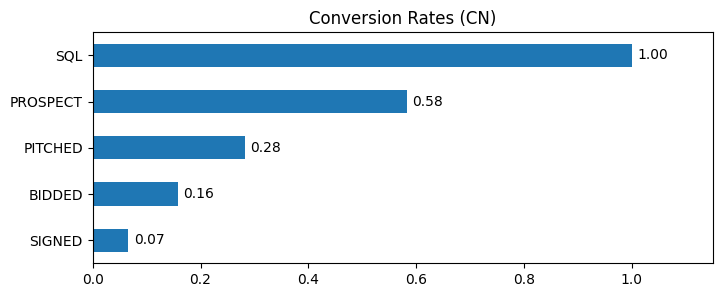

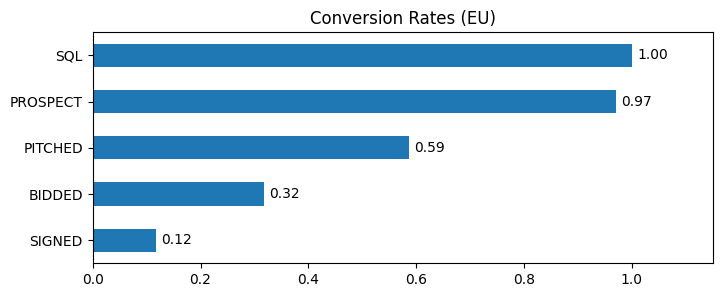

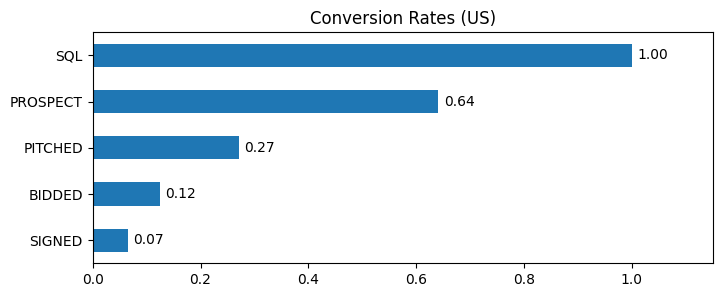

In [262]:
funnel_dict_per_country = build_funnel(funnel_per_country)
for k,v in funnel_dict_per_country.items():
    plot_funnel(v, title=f"Conversion Rates ({k})",figsize=(8, 3))

In [263]:
funnel_per_ind = funnel_ds.groupby(by=['industry', 'intent']).count().loc[:, ['action']]
funnel_per_ind

action
industry        intent                     
AutomotiveParts BIDDED to SIGNED          4
                BIDDED to SQL            14
                MQL to SQL                3
                PITCHED to BIDDED        18
                PITCHED to SQL           12
...                                     ...
Pharmaceuticals PROSPECT to PITCHED      88
                PROSPECT to SQL          88
                SIGNED to PROSPECT       16
                SQL to PROSPECT         158
                SQL to SQL               60

[81 rows x 1 columns]

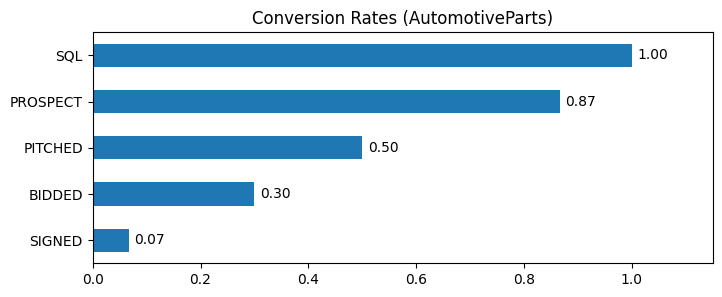

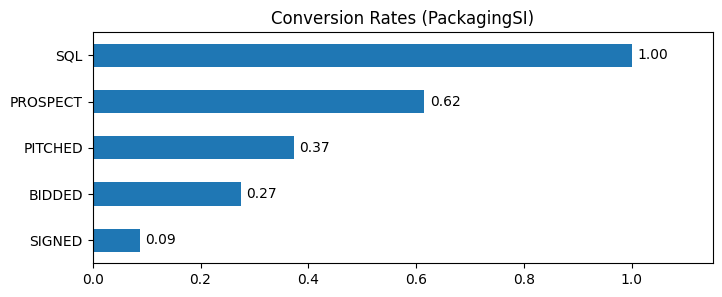

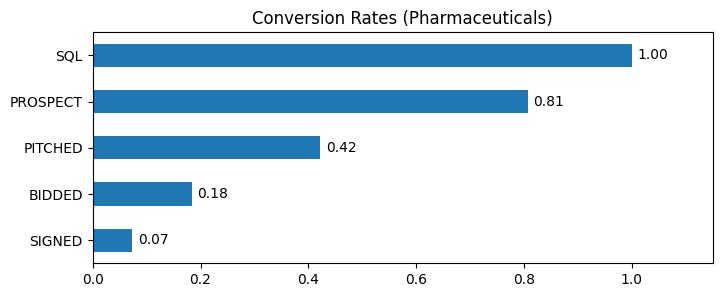

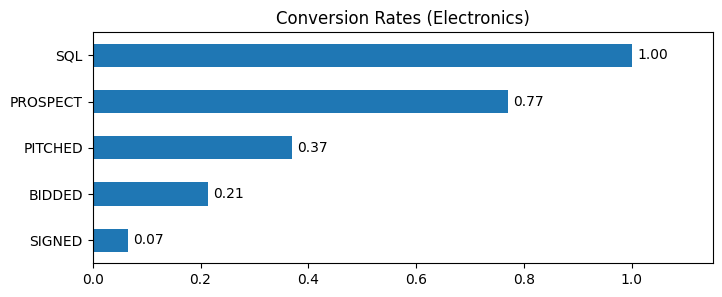

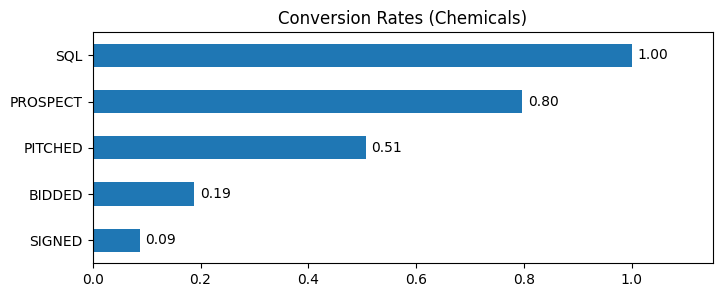

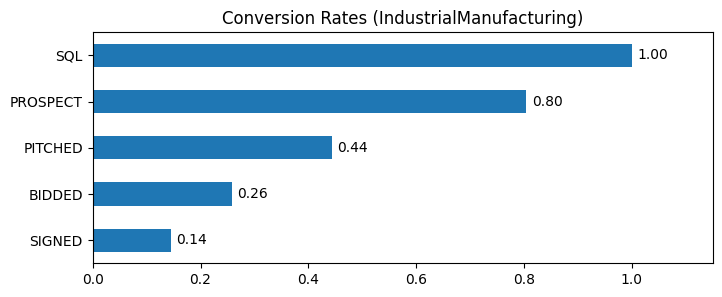

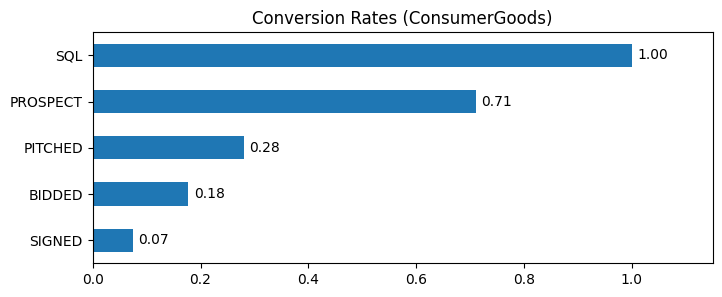

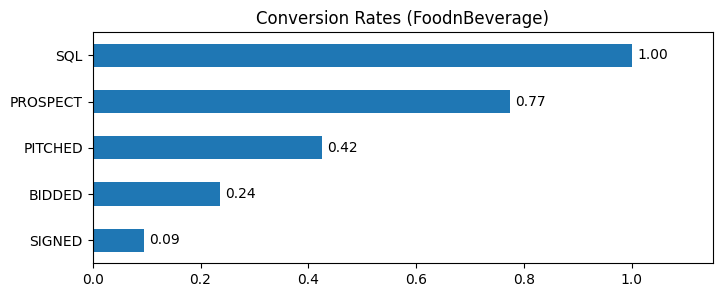

In [264]:
funnel_dict_per_ind = build_funnel(funnel_per_ind)
for k,v in funnel_dict_per_ind.items():
    plot_funnel(v, title=f"Conversion Rates ({k})",figsize=(8, 3))

#### Reference Conversion Rates

##### MQL
- website
    - nb mthly website visitor=2900 monthly
    - website cta rate=0.03
- email
    - online campaigns targets=1000 monthly
    - online campaigns clickthru=0.1
- industry event
    - nb industry events=1 quarterly
    - rawleads industry events=80 * nb industry events
- direct calls
    - rawleads salesreps=30 monthly (?)
- conversion 
    - rawlead2mql website=0.41
    - rawlead2mql online campaign=0.38
    - rawlead2mql industry event=0.3
    - salesrep leads2mql=0.02

##### SQL and later stages
- conversion
    - mql2sql=0.15
    - sql2prospect=0.7
    - prospect2prez=0.7
    - prez2bid=0.6
    - bid2close=0.3
    - customer satisfaction rate=0.98

- delays
    - mql2sql= 1 to 2 weeks
    - sql2prospect= 1 to 2 weeks
    - prospect2prez= 1 to 4 weeks
    - prez2bid= 2 to 12 weeks
    - bid2close= 2 to 12 weeks
    - customer project duration = 12 to 24 weeks


- decay rate=0.15

In [92]:
crm = CustomerRelationManagerSimulator(nb_salesreps=3, nb_mql=10, nb_sql=0, nb_others=0)
with open(p2log, 'w') as f:
    f.write(f"CRM simulation started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"CRM UID: {crm.uid}\n")
    f.write(f"CRM Name: {crm.name}\n")
    f.write(f"{'='* 100}")

crm.run(until=100)

Created 10 MQL accounts
Total accounts created: 10


In [93]:
df = crm.transactions_to_df()
df.loc[df.type != 'system', :]
df.loc[df.action == 'accept', :]
df.tail()

,sender,receiver,intent,action,type,value
timestamp,,,,,,
2027-12-05 07:12:00,acct-700f774d-52a5-4ecc-93e1-e5c8e68ca990,mktg-0d779c94-9dee-4032-a4c9-0c2229a27f57,email campaign,reject,external,NaN
2027-12-05 07:12:00,acct-12d076dd-1daa-4e48-bf96-988ba348dccf,mktg-0d779c94-9dee-4032-a4c9-0c2229a27f57,email campaign,reject,external,NaN
2027-12-05 07:12:00,acct-d5d48307-a03c-4b09-b322-ae68abdb29d6,mktg-0d779c94-9dee-4032-a4c9-0c2229a27f57,email campaign,reject,external,NaN
2027-12-05 07:12:00,acct-3eb35d73-697f-4545-9219-cc818cdaa7af,mktg-0d779c94-9dee-4032-a4c9-0c2229a27f57,email campaign,reject,external,NaN
2027-12-05 07:12:00,acct-bb60277e-da56-4553-a8d4-c45a3a01bafb,mktg-0d779c94-9dee-4032-a4c9-0c2229a27f57,email campaign,reject,external,NaN


In [94]:
crm.account_stats_to_df(int_idx=True)

,timestamp,nb_accounts,LEAD,MQL,SQL,PROSPECT,PITCHED,BIDDED,SIGNED,ACTIVE,STALE
0,1,10,0,9,1,0,0,0,0,0,0
1,2,11,0,10,1,0,0,0,0,0,0
2,3,11,0,10,1,0,0,0,0,0,0
3,4,11,0,9,1,1,0,0,0,0,0
4,5,11,0,9,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
94,95,54,0,5,26,13,3,1,6,0,0
95,96,54,0,5,25,15,2,2,5,0,0
96,97,54,0,5,27,14,1,1,6,0,0
97,98,54,0,5,25,13,4,1,6,0,0


# Sandbox

### Check the countries represented in the data

In [33]:
p2data = Path('../data/account-info-clean.tsv').resolve()
assert p2data.is_file(), p2data

In [40]:
df = pd.read_csv(p2data, sep='\t')
display(df.head())
df.Country = df.Country.str.split('.').apply(lambda x: x[1].strip())
df.head()

,Country,Company Name,Industry
0,Country.EU,EuroPac GmbH,FoodnBeverage
1,Country.EU,Alpine Packaging S.A.,ConsumerGoods
2,Country.EU,PackItalia S.p.A.,Pharmaceuticals
3,Country.EU,DutchFlex BV,IndustrialManufacturing
4,Country.EU,Belgipack NV,Chemicals


,Country,Company Name,Industry
0,EU,EuroPac GmbH,FoodnBeverage
1,EU,Alpine Packaging S.A.,ConsumerGoods
2,EU,PackItalia S.p.A.,Pharmaceuticals
3,EU,DutchFlex BV,IndustrialManufacturing
4,EU,Belgipack NV,Chemicals


In [41]:
df.to_csv(p2data, sep='\t', index=False)

In [34]:
pd.read_csv(p2data, sep='\t').Country.str.split('.').apply(lambda x: x[1]).unique()

array(['EU', 'CN', 'US'], dtype=object)

In [322]:
from utils import account_info_generator

In [323]:
cgen = account_info_generator()

In [329]:
next(cgen)  # skip first

Country                    Country.US
Company Name    RiverPac Systems Inc.
Industry                  Electronics
Name: 5, dtype: object